In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)


import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time

import numpy as np
from dataloader import GraphDataset
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures



2.0.1


## Load Graph data

In [31]:
root_path = 'Dataset/BUSBRA/data-edge/k2/'
mask_dir = 'Dataset/BUSBRA/original/Masks/'
base_dir = 'Dataset/BUSBRA/original/test/'

In [3]:
# Load Train
name_train = 'train'

dataset_train = GraphDataset(root=root_path, name=name_train,use_node_attr=True)
data_size_train = len(dataset_train)

c:\Users\PC-Home\anaconda3\lib\site-packages\torch_geometric\data\in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [4]:
# Load Test
name_test = 'test'

dataset_test = GraphDataset(root=root_path, name=name_test,use_node_attr=True)
data_size_test = len(dataset_test)

In [5]:
def find_indices(tensor, N):
    # Find indices where tensor is equal to N
    indices = (tensor == N).nonzero(as_tuple=True)[0]

    # Convert tensor of indices to list
    indices_list = indices.tolist()

    return indices_list


def delete_indices(tensor, indices):
    # Create a mask where only elements at the given indices are False
    mask = torch.ones(tensor.numel(), dtype=torch.bool)
    mask[indices] = False

    # Reshape the mask to have the same shape as the tensor
    mask = mask.view(tensor.shape)

    # Index tensor with the mask to get tensor with the specified elements removed
    tensor = tensor[mask]

    return tensor

In [6]:
# Define Graph Object
class GraphNodeObject:
    def __init__(self):
        self.x = None
        self.edge_index = None
        self.y = None
        self.train_mask = None
        self.val_mask = None
        self.test_mask = None
        self.num_features = None
        self.num_classes = None

In [7]:
# Process TRAINING data

class GraphNodeObject:
    def __init__(self):
        self.x = None
        self.edge_index = None
        self.y = None
        self.train_mask = None
        self.val_mask = None
        self.test_mask = None
        self.num_features = None
        self.num_classes = None

# Define the number of elements you want in your list
N = len(dataset_train)

# Create a list of `MyObject` instances
processed_dataset_train = [GraphNodeObject() for _ in range(N)]

#Remove the prefix node label in feature
feat_temp = dataset_train[0].x[:, :-3]
_ , new_num_feat = feat_temp.size()

processed_dataset_train[0].x = feat_temp
processed_dataset_train[0].edge_index = dataset_train[0].edge_index
processed_dataset_train[0].y = torch.argmax(dataset_train[0].x[:,-3:], dim=1)

processed_dataset_train[0].num_features = new_num_feat
processed_dataset_train[0].num_classes = 3

In [8]:
node_labels_train = dataset_train[0].x[:,-3:]

dataset_train_mask_train = torch.zeros(len(node_labels_train), dtype=torch.bool)
dataset_train_mask_train[:] = True

dataset_train_mask_test = torch.zeros(len(node_labels_train), dtype=torch.bool)
dataset_train_mask_test[:] = False

processed_dataset_train[0].train_mask = dataset_train_mask_train
processed_dataset_train[0].test_mask = dataset_train_mask_test

In [9]:
len(processed_dataset_train[0].x)

224324

In [10]:
# Process TEST data

# Define the number of elements you want in your list
N = len(dataset_test)

# Create a list of `MyObject` instances
processed_dataset_test = [GraphNodeObject() for _ in range(N)]

#Remove the prefix node label in feature
feat_temp = dataset_test[0].x[:, :-3]
_ , new_num_feat = feat_temp.size()

processed_dataset_test[0].x = feat_temp
processed_dataset_test[0].edge_index = dataset_test[0].edge_index
processed_dataset_test[0].y = torch.argmax(dataset_test[0].x[:,-3:], dim=1)

processed_dataset_test[0].num_features = new_num_feat
processed_dataset_test[0].num_classes = 3

In [11]:
node_labels_test = dataset_test[0].x[:,-3:]

dataset_test_mask_train = torch.zeros(len(node_labels_test), dtype=torch.bool)
dataset_test_mask_train[:] = False

dataset_test_mask_test = torch.zeros(len(node_labels_test), dtype=torch.bool)
dataset_test_mask_test[:] = True

processed_dataset_test[0].train_mask = dataset_test_mask_train
processed_dataset_test[0].test_mask = dataset_test_mask_test

In [12]:
# Merging two sets

edge_index_temp1 = dataset_train[0].edge_index
edge_index_temp2 = len(dataset_train.x) + dataset_test[0].edge_index
edge_index_temp = torch.cat((edge_index_temp1, edge_index_temp2), dim=1)

N1 = len(dataset_train.x)
N2 = len(dataset_test.x)

N = N1 + N2

# Create a list of `MyObject` instances
processed_dataset_all = [GraphNodeObject() for _ in range(N)]

In [13]:
feat_temp1 = dataset_train[0].x[:, :-3]
feat_temp2 = dataset_test[0].x[:, :-3]
feat_temp = torch.cat((feat_temp1, feat_temp2), dim=0)


edge_index_temp1 = dataset_train[0].edge_index
edge_index_temp2 = len(dataset_train.x) + dataset_test[0].edge_index
edge_index_temp = torch.cat((edge_index_temp1, edge_index_temp2), dim=1)

y_temp1 = torch.argmax(dataset_train[0].x[:,-3:], dim=1)
y_temp2 = torch.argmax(dataset_test[0].x[:,-3:], dim=1)
y_temp = torch.cat((y_temp1, y_temp2), dim=0)

#Remove the prefix node label in feature
_ , new_num_feat = feat_temp.size()

processed_dataset_all[0].x = feat_temp
processed_dataset_all[0].edge_index = dataset_test[0].edge_index
processed_dataset_all[0].y = y_temp

processed_dataset_all[0].num_features = new_num_feat
processed_dataset_all[0].num_classes = 3

In [14]:
len_node_labels_all = N1 +  N2


dataset_all_mask_train = torch.zeros(len_node_labels_all, dtype=torch.bool)
dataset_all_mask_train[:N1] = True
dataset_all_mask_train[N1:] = False

In [15]:
len_node_labels_all = len(node_labels_train) +  len(node_labels_test)



dataset_all_mask_train = torch.zeros(len_node_labels_all, dtype=torch.bool)
dataset_all_mask_train[:N1] = True
dataset_all_mask_train[N1:] = False

dataset_all_mask_test = torch.zeros(len_node_labels_all, dtype=torch.bool)
dataset_all_mask_test[:N1] = False
dataset_all_mask_test[N1:] = True

processed_dataset_all[0].train_mask = dataset_all_mask_train
processed_dataset_all[0].test_mask = dataset_all_mask_test

## Training Graph Convolutional Network (GCN)



In [16]:
from torch_geometric.nn import GCNConv
import torch
from torch.nn import Linear
import torch.nn.functional as F



#==============================================================
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(processed_dataset_train[0].num_features, 256)
        self.conv2 = GCNConv(256, 128)

        self.conv3 = GCNConv(128, processed_dataset_train[0].num_classes)


    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        # x = self.lin1(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv3(x, edge_index)
        return x

#==============================================================


model = GCN(hidden_channels=256)
print(model)

GCN(
  (conv1): GCNConv(512, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 3)
)


In [17]:
# Class Weights with Focal Loss for Imbalanced MultiClass
y_train = processed_dataset_all[0].y
class_counts = np.bincount(y_train)
num_classes = len(class_counts)
total_samples = len(y_train)

class_weights = []
for count in class_counts:
    weight = 1 / (count / total_samples)
    class_weights.append(weight)

# class_weights[0] *= 0.1
# class_weights[1] *= 0.05

class_weights = torch.FloatTensor(class_weights)

In [18]:
class_weights

tensor([21.7356, 25.7926,  1.0926])

In [19]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = (self.alpha[targets] * (1 - pt) ** self.gamma * ce_loss).mean()
        return loss

In [20]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
# criterion = torch.nn.CrossEntropyLoss()
criterion = FocalLoss(alpha=class_weights, gamma=5)

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(processed_dataset_all[0].x, processed_dataset_all[0].edge_index)  # Perform a single forward pass.
      loss = criterion(out[processed_dataset_all[0].train_mask], processed_dataset_all[0].y[processed_dataset_all[0].train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(processed_dataset_all[0].x, processed_dataset_all[0].edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[processed_dataset_all[0].test_mask] == processed_dataset_all[0].y[[0].test_mask]  # Check against ground-truth labels.processed_dataset_all
      test_acc = int(test_correct.sum()) / int(processed_dataset_all[0].test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


# for epoch in range(1, 201):
#     loss = train()
#     print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')


def train_model(model, criterion, optimizer, num_epochs=25, early_stopping = None):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    best_loss = float('inf')
    
    train_accuracy = []
    val_accuracy = []
        
    val_losses = []
    train_losses = []

    count_stopping = 0

    for epoch in range(num_epochs):
        print('\nEpoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0.0
        
        model.train(True)
        optimizer.zero_grad()  # Clear gradients.

        out = model(processed_dataset_all[0].x, processed_dataset_all[0].edge_index)  # Perform a single forward pass.
        loss = criterion(out[processed_dataset_all[0].train_mask], processed_dataset_all[0].y[processed_dataset_all[0].train_mask])  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.

        pred = out.argmax(dim=1)

        running_loss += loss.data
        running_corrects += torch.sum(pred[processed_dataset_all[0].train_mask] == processed_dataset_all[0].y[processed_dataset_all[0].train_mask]).to(torch.float32)  # Check against ground-truth labels.

        epoch_loss = running_loss
        epoch_acc = running_corrects / int(processed_dataset_all[0].train_mask.sum())

        train_accuracy.append(epoch_acc.item())
        train_losses.append(epoch_loss.item())

        print('Train \tLoss: {:.4f} \tAcc: {:.4f}'.format(
                epoch_loss, epoch_acc))
        
        ## Validation
        running_loss = 0.0
        running_corrects = 0.0

        model.train(False)

        out = model(processed_dataset_all[0].x, processed_dataset_all[0].edge_index)  # Perform a single forward pass.
        loss = criterion(out[processed_dataset_all[0].test_mask], processed_dataset_all[0].y[processed_dataset_all[0].test_mask])  # Compute the loss solely based on the training nodes.
        
        pred = out.argmax(dim=1)

        running_loss += loss.data
        running_corrects += torch.sum(pred[processed_dataset_all[0].test_mask] == processed_dataset_all[0].y[processed_dataset_all[0].test_mask]).to(torch.float32)  # Check against ground-truth labels.


        epoch_loss = running_loss
        epoch_acc = running_corrects / int(processed_dataset_all[0].test_mask.sum())

        val_accuracy.append(epoch_acc.item())
        val_losses.append(epoch_loss.item())


        print('Val \tLoss: {:.4f} \tAcc: {:.4f}'.format(
                epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            print('Monitored metric has improved from {:.4f} --> {:.4f}'.format(best_loss, epoch_loss))
            best_loss = epoch_loss
            best_acc = epoch_acc
            best_model_wts = model.state_dict()
            if not os.path.exists('Result/'):
                os.makedirs('Result/')
            torch.save(model.state_dict(), 'Result/' + 'checkpoint_net.pt') 
            count_stopping = 0
        else:
            if(early_stopping != None):
                print('EarlyStopping counter: {:d} out of {:d}'.format(count_stopping, early_stopping))
                count_stopping += 1
           

        if(early_stopping != None):
            if(count_stopping == early_stopping):
                print("Early Stopping")
                break
        
        
        # early_stopping(epoch_loss, model)       
        # if early_stopping.early_stop:
        #     print("Early stopping")
        #     break
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, train_accuracy, train_losses, val_accuracy, val_losses, epoch



<IPython.core.display.Javascript object>

In [21]:
model, train_accuracy, train_losses, val_accuracy, val_losses, epoch = train_model(model, 
                                                                                   criterion, 
                                                                                   optimizer, num_epochs=200, early_stopping = None)


Epoch 1/200
----------
Train 	Loss: 1.0505 	Acc: 0.0392
Val 	Loss: 0.6294 	Acc: 0.0343
Monitored metric has improved from inf --> 0.6294

Epoch 2/200
----------
Train 	Loss: 0.8523 	Acc: 0.0528
Val 	Loss: 0.4994 	Acc: 0.0653
Monitored metric has improved from 0.6294 --> 0.4994

Epoch 3/200
----------
Train 	Loss: 0.6870 	Acc: 0.0739
Val 	Loss: 0.4040 	Acc: 0.0839
Monitored metric has improved from 0.4994 --> 0.4040

Epoch 4/200
----------
Train 	Loss: 0.5567 	Acc: 0.1024
Val 	Loss: 0.3296 	Acc: 0.0840
Monitored metric has improved from 0.4040 --> 0.3296

Epoch 5/200
----------
Train 	Loss: 0.4545 	Acc: 0.1448
Val 	Loss: 0.2698 	Acc: 0.0842
Monitored metric has improved from 0.3296 --> 0.2698

Epoch 6/200
----------
Train 	Loss: 0.3722 	Acc: 0.2063
Val 	Loss: 0.2210 	Acc: 0.0931
Monitored metric has improved from 0.2698 --> 0.2210

Epoch 7/200
----------
Train 	Loss: 0.3074 	Acc: 0.2901
Val 	Loss: 0.1814 	Acc: 0.2789
Monitored metric has improved from 0.2210 --> 0.1814

Epoch 8/200
---

After training the model, we can check its test accuracy:

In [22]:
# Load the best model
model.load_state_dict(torch.load('Result/' + 'checkpoint_net.pt'))

<All keys matched successfully>

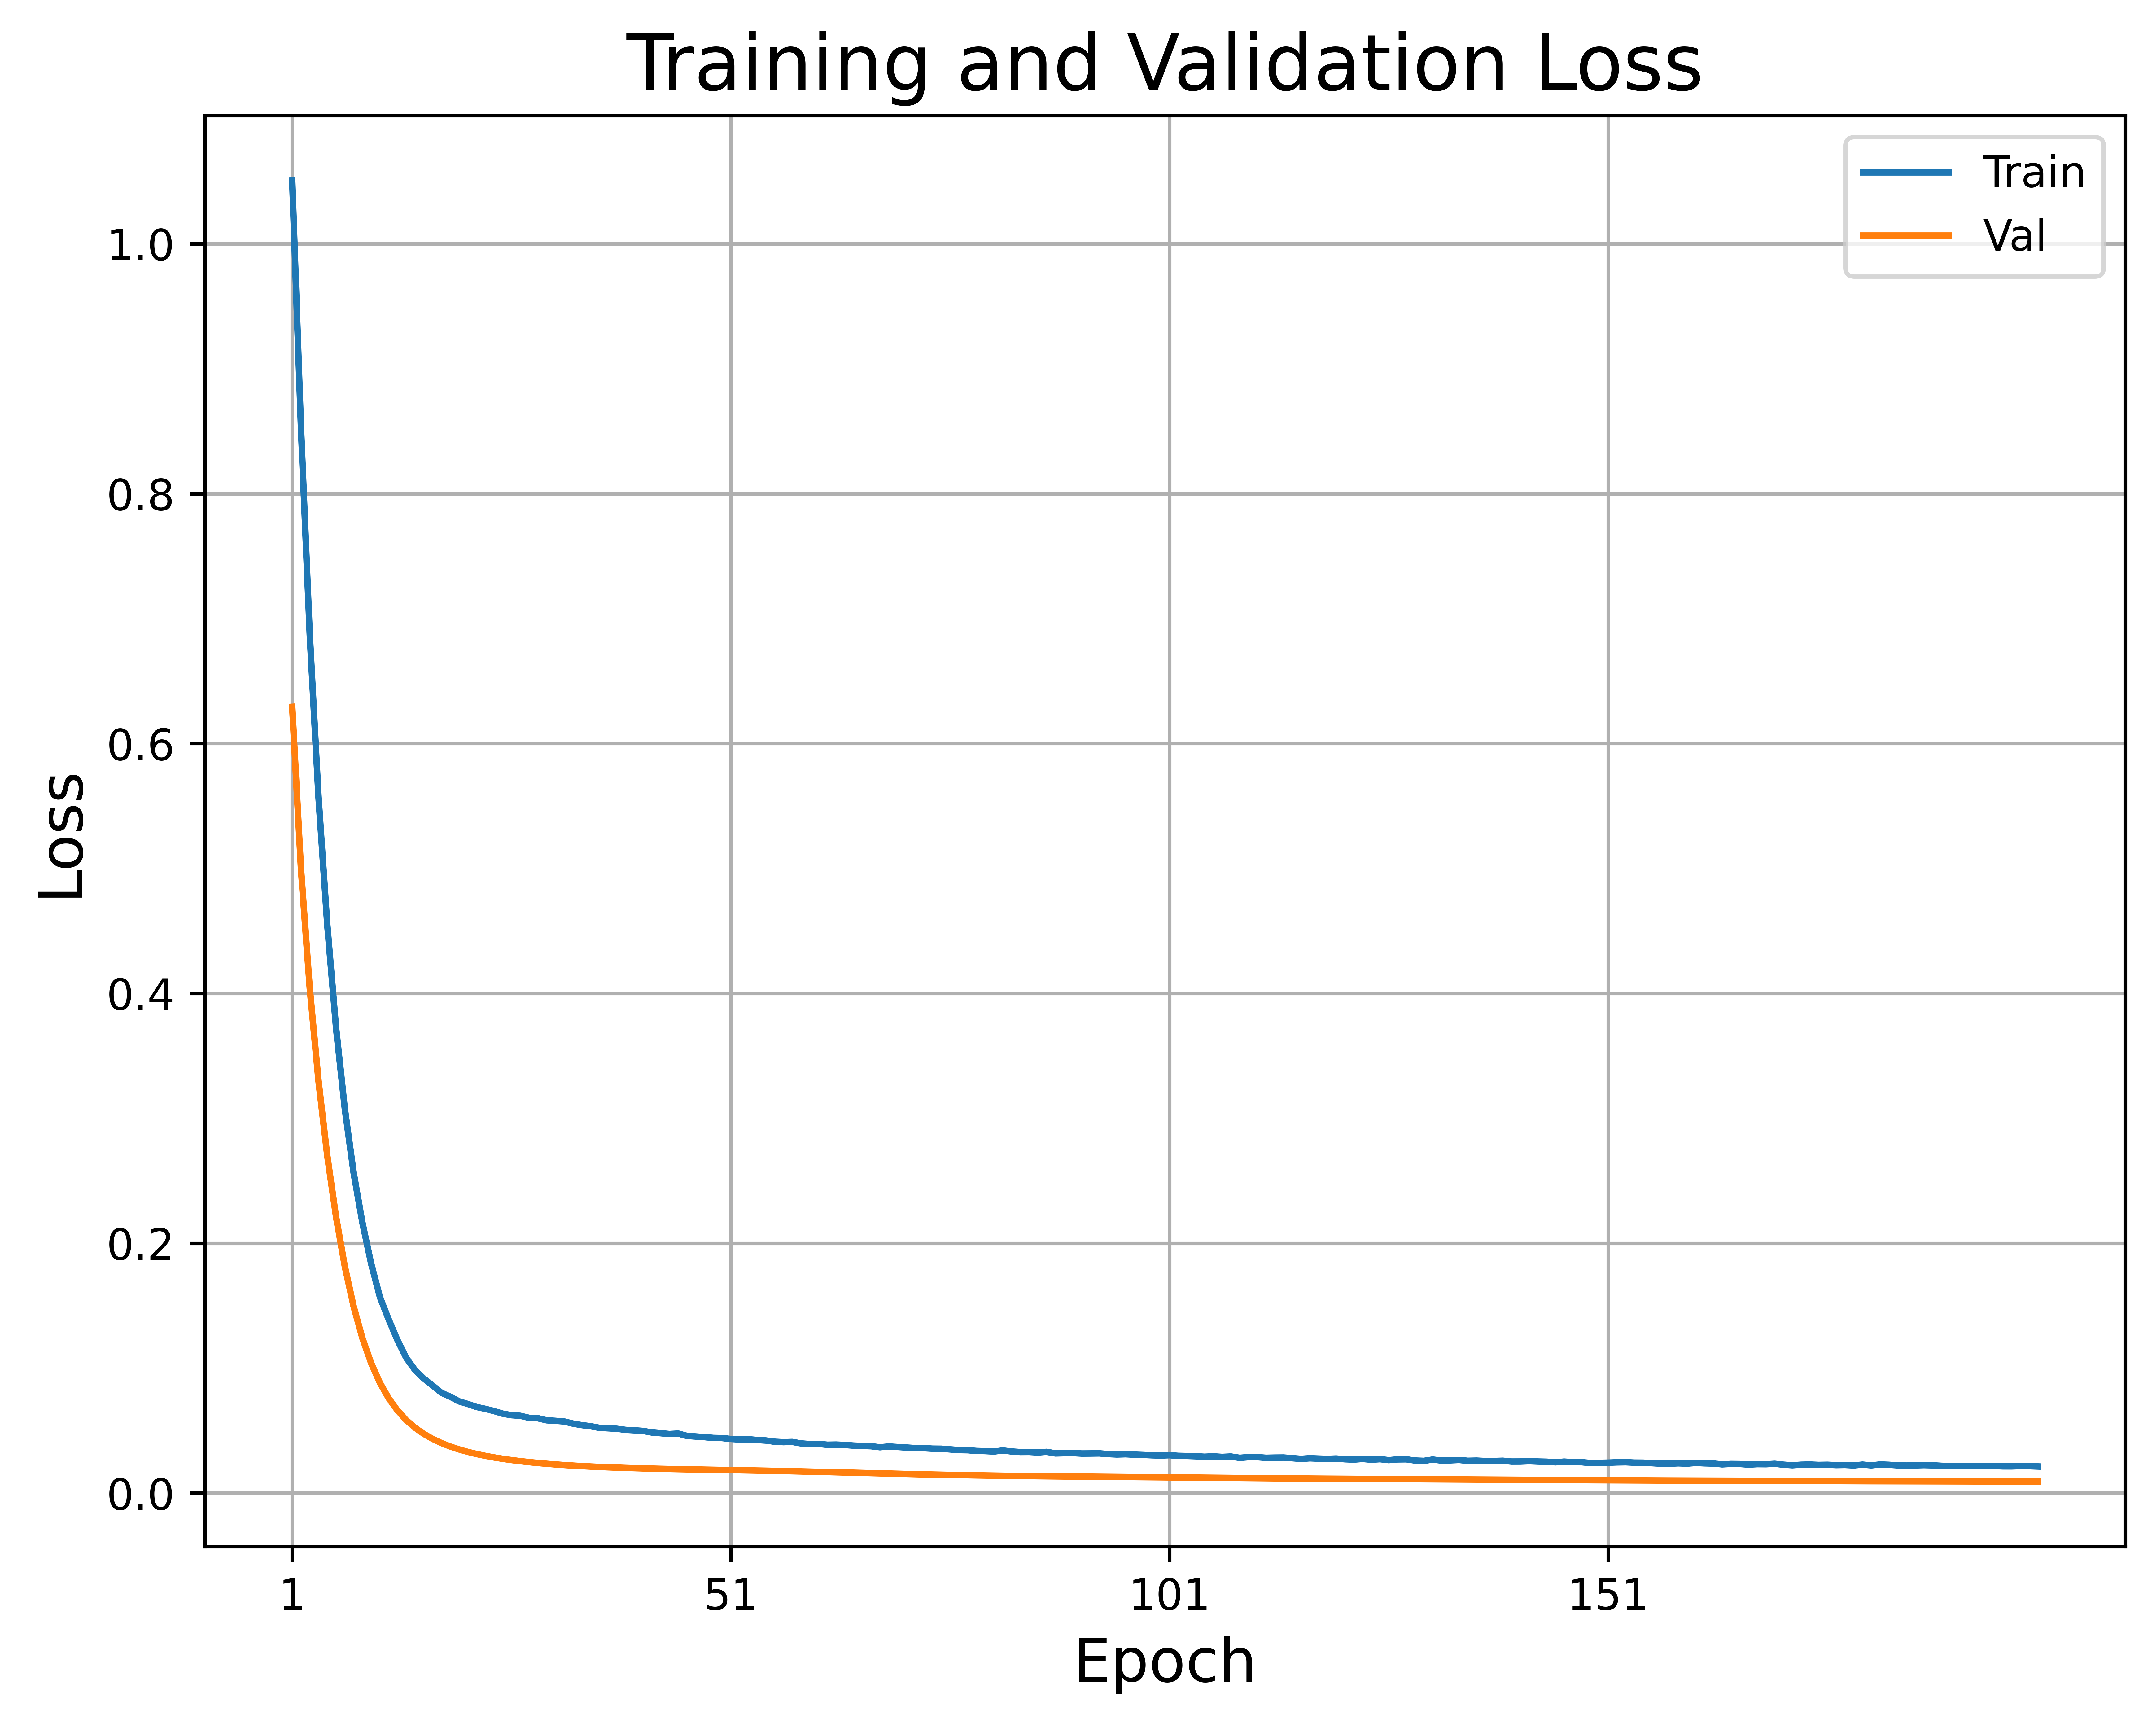

In [23]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8.00,6.00),dpi=1000)
plt.title("Training and Validation Loss",fontsize=18)
plt.plot(range(1,epoch+2),train_losses,label="Train")
plt.plot(range(1,epoch+2),val_losses,label="Val")
plt.xlabel("Epoch",fontsize=14)
plt.ylabel("Loss",fontsize=14)
plt.xticks(np.arange(1, epoch+2, 50.0))
plt.legend()
plt.grid()
plt.show()

              precision    recall  f1-score   support

           0     0.8802    0.9876    0.9308      2588
           1     0.9493    0.9968    0.9725      2179
           2     0.9993    0.9911    0.9952     51429

    accuracy                         0.9911     56196
   macro avg     0.9429    0.9918    0.9661     56196
weighted avg     0.9919    0.9911    0.9913     56196



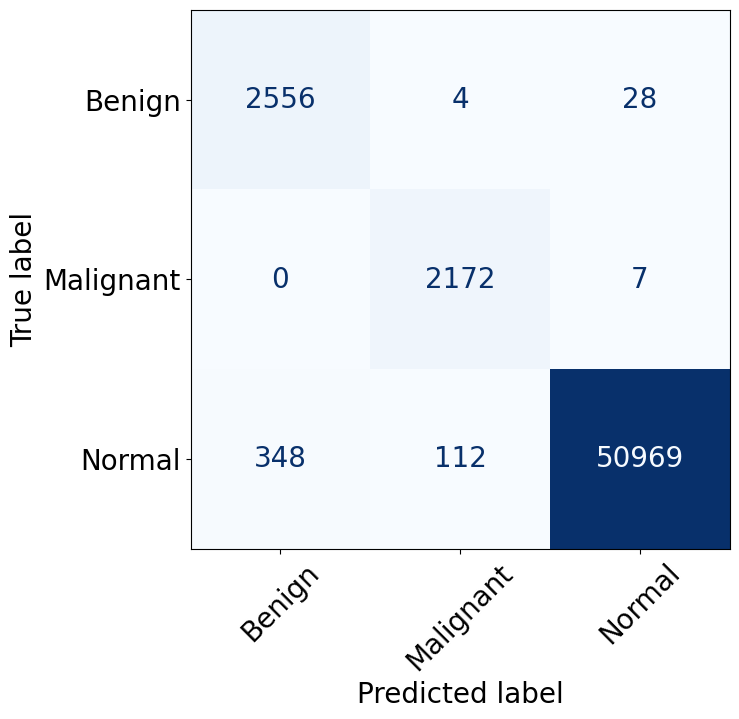

Normalized confusion matrix


**Overall Results**
Accuracy Result: 99.11%
Precision Result: 94.93%
Recall Result: 99.68%
F-Score Result: 97.25%


In [24]:
from sklearn.metrics import classification_report
from models import *
import seaborn as sns
from utils import *

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd

def plot_cm_by_me(y_true, y_pred, classes,
                          normalize=False,
                          title= 'Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import itertools   
    from sklearn.utils.multiclass import unique_labels
    from sklearn.metrics import confusion_matrix
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)
        

    #fig, ax = plt.plot()
    plt.figure(figsize=(7.00,7.00),dpi=1200)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.colorbar()
    # We want to show all ticks...
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)


    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j]*100, fmt),
                    ha="center", va="center",fontsize=20,
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.title(title, fontsize=22)
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.savefig('Result/' +'confusion_mat.svg', bbox_inches='tight')

@torch.no_grad()
def inference():
    model.eval()
    correct = 0
    y_pred = []
    y_true = []
    # for data in loader:  # Iterate in batches over the training/test dataset.
        # data = data.to(device)
    out = model(processed_dataset_all[0].x, processed_dataset_all[0].edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
        #correct += int((pred == data.y).sum())  # Check against ground-truth labels
    pred_test = pred[processed_dataset_all[0].test_mask]
    true_test = processed_dataset_all[0].y[processed_dataset_all[0].test_mask]

    # y_true.extend(dataset_me[0].y.cpu().numpy())
    # y_pred.extend(np.squeeze(pred_test.cpu().numpy().T))
    y_true = true_test.numpy()
    y_pred = pred_test.numpy()
    

    report = classification_report(y_true, y_pred, digits=4)
    print(report)
    cm = confusion_matrix(y_true, y_pred)
    # cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # plot the confusion matrix

    display_labels = [ 'Benign','Malignant', 'Normal']
    plot_cm(cm, display_labels=display_labels)
    # print(cm)
    
    
    plot_cm_by_me(y_true, y_pred, classes=display_labels,  normalize=True)
    plt.show()

    #return torch.sum(y_pred == y_true).item() / len(y_true)      
    # return correct / len(loader.dataset) # Derive ratio of correct predictions.

    #Accuracy Result
    acc = accuracy_score(y_true, y_pred)
    #Precision, Recall and F-Score (For the whole dataset)
    results_all = precision_recall_fscore_support(y_true, y_pred, average='macro',zero_division = 1)
    #Precision, Recall and F-Score (For each Class)
    results_class = precision_recall_fscore_support(y_true, y_pred, average=None, zero_division = 1)

    #Organise the Results into a Dataframe
    metric_columns = ['Precision','Recall', 'F-Score','S']
    all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
#     all_df.columns = metric_colu
    
    print('**Overall Results**')
    print('Accuracy Result: %.2f%%'%(acc*100)) #Accuracy of the whole Dataset
    print('Precision Result: %.2f%%'%(all_df.iloc[1,0]*100))#Precision of the whole Dataset
    print('Recall Result: %.2f%%'%(all_df.iloc[1,1]*100))#Recall of the whole Dataset
    print('F-Score Result: %.2f%%'%(all_df.iloc[1,2]*100))#F-Score of the whole Dataset


inference()

# Image-Level Classification

In [32]:
import cv2
from skimage.segmentation import slic
from scipy.spatial.distance import cdist
from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models

def normalize_rows(arr):
    min_values = arr.min(axis=1)
    max_values = arr.max(axis=1)
    normalized_arr = (arr - min_values[:, np.newaxis]) / (max_values - min_values)[:, np.newaxis]
    return normalized_arr

def find_k_min_indices_desc(array, k):
    if k > len(array):
        raise ValueError("K is larger than the size of the array.")
    sorted_indices = np.argsort(array)
    k_min_indices = sorted_indices[:k]
    return k_min_indices

def resize_superpixel(superpixel, target_size):

    # Resize the superpixel using bilinear interpolation
    resized_superpixel = resize(superpixel, (target_size, target_size), 
                                mode='reflect', anti_aliasing=True)

    return resized_superpixel

def extract_features(model, img_array):
    img_array = np.expand_dims(img_array, axis=0)

    features = model.predict(img_array, verbose=0)
    return features.flatten()

def generate_graphs(filename, model, k=7):

    attrs = []
    edges = []
    node_id = 0
    edge = 0

    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    segments_slic = slic(img, n_segments=150, compactness=50)

    segments_ids = np.unique(segments_slic)
    centers = np.array([np.mean(np.nonzero(segments_slic==i),axis=1) for i in segments_ids])

    # Calculate the average intensity for each superpixel
    unique_segments = np.unique(segments_slic)
    average_intensities = []

    for seg_id in unique_segments:
        mask = segments_slic == seg_id
        average_intensity = np.mean(img[mask], axis=0)
        average_intensity = average_intensity.astype(int)
        average_intensities.append(average_intensity)

    average_intensities = np.array(average_intensities)

    # Compute distances between each pair of superpixels based on Average intensity superpixel
    distances_intensity = normalize_rows(cdist(average_intensities, average_intensities, metric='euclidean'))

    # Compute distances between each pair of superpixels based on location of Center
    distances_pos = normalize_rows(cdist(centers, centers, metric='euclidean'))

    # Combine distance
    distances = (distances_pos + distances_intensity)/2

    for i in unique_segments:       #Scan all the superpixel in image

        edges_image = find_k_min_indices_desc(distances[i-1], k)
        edges_image = edges_image + 1
        edges_image = edges_image + node_id

        for j in edges_image:        # Forming edges
            if(j != (i+node_id)):
                edges.append([i+node_id, j])
                edge += 1



    for (i, segment_val) in enumerate(np.unique(segments_slic)):
            
        # Mask for the current superpixel
        mask = segments_slic == segment_val

        # Find the bounding box of the superpixel
        positions = np.where(mask)
        top, left = np.min(positions, axis=1)
        bottom, right = np.max(positions, axis=1)
            
        # Extract the superpixel image
        superpixel_image = img[top:bottom+1, left:right+1]

        resized_superpixel = resize_superpixel(superpixel_image, 32)

        feature_vector = extract_features(model, resized_superpixel)
        feature_vector = feature_vector.reshape(1, -1)
        feature_vector = feature_vector.tolist()
        feature_vector = feature_vector[0]

        attrs.append(feature_vector)


    attrs = torch.tensor(attrs)
    edges = torch.tensor(edges)
    edges = edges - 1
    edges = edges.t()

    return attrs, edges, segments_slic, centers, img


In [33]:
# from torch_geometric.nn import GCNConv
# import torch
# from torch.nn import Linear
# import torch.nn.functional as F

# class GCN(torch.nn.Module):
#     def __init__(self, hidden_channels):
#         super().__init__()
#         torch.manual_seed(1234567)
#         self.conv1 = GCNConv(processed_dataset_train[0].num_features, 256)
#         self.conv2 = GCNConv(256, 128)

#         # self.lin1 = Linear(32, 32)
#         # self.lin2 = Linear(32, dataset_me[0].num_classes)
#         self.conv3 = GCNConv(128, processed_dataset_train[0].num_classes)
#         # self.conv4 = GCNConv(hidden_channels, dataset_me[0].num_classes)

#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index).relu()
#         x = self.conv2(x, edge_index).relu()
#         # x = self.lin1(x)
#         x = F.dropout(x, p=0.5, training=self.training)

#         x = self.conv3(x, edge_index)
#         return x


# model = GCN(hidden_channels=256)
# # Load the best model
# model.load_state_dict(torch.load('Result/' + 'checkpoint_net.pt'))
# model.eval()

In [34]:
def find_indexes(lst, num):
    return [i for i, x in enumerate(lst) if x == num]

def find_indices_lst(lst, value):
    return [i for i, row in enumerate(lst) if value in row]

def count_node_class(tensor):
    unique_elements, counts = torch.unique(tensor, return_counts=True)
    element_counts = dict(zip(unique_elements.tolist(), counts.tolist()))
    
    for i in [0, 1, 2]:
        if i == 0:
            count_0 = element_counts.get(i, 0)
        elif i == 1: 
            count_1 = element_counts.get(i, 0) 
        elif i == 2:
            count_2 = element_counts.get(i, 0) 
        
        print(f"Count of {i}: {element_counts.get(i, 0)}")

    return count_0, count_1, count_2

def class_label(c0, c1, c2):
    
    if c0!=0 or c1 != 0:
        if c0 >= c1:
            label = 1
        elif c1>c0 and c1>2:
            label = 2
        else:
            label = 3
    else:
        label = 3

    return label

def encode_class(folder_name):
    if folder_name == 'benign':
        label = 1
    elif folder_name == 'malignant':
        label = 2
    else:
        label = 3
    
    return label

####################################################################
def node_mask_indices(tensor):

    # Find where the nodes are abnormal
    matches = tensor != 2
    
    # Get the indices of those elements
    ind_mask = torch.nonzero(matches)
    
    return ind_mask

def check_number_in_tensor(i, arr):
    return (arr == i).any().item()

def segment_area(img, segments_slic, ind_mask):
    M, N, _ = np.shape(img)
    segment_mask = np.zeros((M, N), dtype=bool)

    for (i, segment_val) in enumerate(np.unique(segments_slic)):
        if check_number_in_tensor(i, ind_mask):
            mask = segments_slic == segment_val
            segment_mask = np.logical_or(segment_mask, mask) 
        
    return segment_mask

def replace_prefix(filename, new_prefix):
    # Split the filename into prefix and the rest
    parts = filename.split('_', 1)
    
    # If the filename doesn't have a prefix, return it as is
    if len(parts) < 2:
        return filename
    
    # Return the new filename with the replaced prefix
    return new_prefix + '_' + parts[1]

def calculate_iou(image1, image2):
    """
    Calculate the Intersection over Union (IoU) of two binary segmentation images.
    """
    intersection = np.logical_and(image1, image2).sum()
    union = np.logical_or(image1, image2).sum()
    
    # Avoid division by zero
    if union == 0:
        return 0
    else:
        iou = intersection / union
        return iou

def calculate_dice(image1, image2):
    """
    Calculate the Dice Coefficient for two binary segmentation images.
    """
    # Ensure binary representation is in {0, 1}
    image1_binary = np.clip(image1, 0, 1)
    image2_binary = np.clip(image2, 0, 1)
    
    intersection = np.sum(image1_binary * image2_binary)
    sum_images = np.sum(image1_binary) + np.sum(image2_binary)
    
    # Prevent division by zero
    if sum_images == 0:
        return 1 if intersection == 0 else 0  # Handles the case where both images are empty or one is empty
    
    dice = 2. * intersection / sum_images
    
    return dice


def load_true_mask(image_file, mask_dir):
    image_mask_name = replace_prefix(image_file, 'mask')
    image_mask_name = mask_dir + image_mask_name
    true_mask = cv2.imread(image_mask_name, cv2.IMREAD_GRAYSCALE)
    # image_mask_name = mask_dir + image_mask_name
    
    return true_mask

In [35]:
from torch_geometric.nn import GCNConv
import torch
from torch.nn import Linear
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(processed_dataset_train[0].num_features, 256)
        self.conv2 = GCNConv(256, 128)

        self.conv3 = GCNConv(128, processed_dataset_train[0].num_classes)


    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        # x = self.lin1(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv3(x, edge_index)
        return x

model = GCN(hidden_channels=256)
# Load the best model
model.load_state_dict(torch.load('Result/' + 'checkpoint_net.pt'))
model.eval()
out = model(processed_dataset_all[0].x, processed_dataset_all[0].edge_index)
pred = out.argmax(dim=1)  # Use the class with highest probability.
        #correct += int((pred == data.y).sum())  # Check against ground-truth labels
pred_test = pred[processed_dataset_all[0].test_mask]

In [36]:
def find_indexes(lst, num):
    return [i for i, x in enumerate(lst) if x == num]

idx_status = find_indexes(pred_test[:143], 0)
print(idx_status)

[73, 74, 76]


In [37]:
import os
from PIL import Image
import cv2
from skimage.segmentation import slic
from scipy.spatial.distance import cdist
from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models

from torch_geometric.io import read_txt_array

# root_path = 'Dataset/BUSI-with-GT/data-edge/k7/'
name = 'test/raw/test_image_file_name.txt'
# mask_dir = 'Dataset/BUSI-with-GT/original/Masks/'

import pandas as pd

# Specify the file path
file_path = root_path+name

# Read the file into a pandas DataFrame
df = pd.read_csv(file_path,header = None, sep='\\')
df_value = df.values.tolist()

def find_indices_lst(lst, value):
    return [i for i, row in enumerate(lst) if value in row]

# Placeholder for your prediction function
def predict(image):
    # Your prediction logic here
    return 'unknown'  # Replace or modify with your prediction logic

# Define the base directory containing the subfolders



model_path = root_path + 'Vgg_model.h5'

model_vgg = tf.keras.models.load_model(model_path)

model = Model(model_vgg.input, model_vgg.layers[-2].output)

img_correct = 0.0
total_img = 0.0

y_pred_img = []
y_true_img = []

dice_dataset = []
iou_dataset = []

count_break = 0

# Loop through each subfolder
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    
    if os.path.isdir(folder_path):
        # Loop through each image in the subfolder
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)
            
            # Check if the file is an image
            if image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Load and predict the image
                # image = Image.open(image_path)
                x, edges_index, segments_slic, centers, img = generate_graphs(image_path, model, k=7)

                indices = find_indices_lst(df_value, image_file)
                # idx_status = indices
                node_status = pred_test[min(indices):max(indices)+1]
                c0, c1, c2 = count_node_class(node_status)
                predict_label = class_label(c0, c1, c2)
                true_label = encode_class(folder)

                y_pred_img.append(predict_label)
                y_true_img.append(true_label)

                print(idx_status)
                idx_status = find_indexes(node_status, 0)

                # img_correct += predict_label == true_label 
                # total_img += 1
                

                print(idx_status)


                ## Perform segmentation:
                ind_mask = node_mask_indices(node_status)
                segment_mask = segment_area(img, segments_slic, ind_mask)
                true_mask = load_true_mask(image_file, mask_dir)

                dice = calculate_dice(segment_mask, true_mask)
                dice_dataset.append(dice)
                print(dice)

                iou = calculate_iou(segment_mask, true_mask)
                iou_dataset.append(iou)
                print(iou)
                
                count_break += 1
                
                # Print the folder name (label) along with the image file name
                print(f"Folder: {folder} | Image: {image_file}")




Count of 0: 3
Count of 1: 0
Count of 2: 153
[73, 74, 76]
[73, 74, 76]
0.7104383723216041
0.5509146341463415
Folder: benign | Image: bus_0008-r.png
Count of 0: 1
Count of 1: 0
Count of 2: 139
[73, 74, 76]
[29]
0.8042744656917885
0.6726246472248354
Folder: benign | Image: bus_0013-l.png
Count of 0: 17
Count of 1: 0
Count of 2: 126
[29]
[27, 32, 33, 35, 43, 46, 47, 52, 54, 57, 62, 64, 65, 66, 68, 75, 76]
0.9064048799085017
0.8288303991633258
Folder: benign | Image: bus_0024-r.png
Count of 0: 6
Count of 1: 0
Count of 2: 134
[27, 32, 33, 35, 43, 46, 47, 52, 54, 57, 62, 64, 65, 66, 68, 75, 76]
[50, 53, 58, 61, 63, 106]
0.7757197054228967
0.6336128326649654
Folder: benign | Image: bus_0028-r.png
Count of 0: 2
Count of 1: 0
Count of 2: 154
[50, 53, 58, 61, 63, 106]
[29, 35]
0.7049115913555992
0.5442961165048543
Folder: benign | Image: bus_0033-l.png
Count of 0: 5
Count of 1: 1
Count of 2: 150
[29, 35]
[32, 34, 35, 112, 117]
0.40562670585765276
0.25441137740321307
Folder: benign | Image: bus_00

In [38]:
# Analyze INTERPRETABILITY

avg_iou = sum(iou_dataset) / len(iou_dataset)
avg_dice = sum(dice_dataset) / len(dice_dataset)
print('IoU: ', avg_iou)
print('Dice: ', avg_dice)


IoU:  0.6974451316706038
Dice:  0.8117845047648833


In [39]:
#Accuracy Result
acc = accuracy_score(y_true_img, y_pred_img)
 #Precision, Recall and F-Score (For the whole dataset)
results_all = precision_recall_fscore_support(y_true_img, y_pred_img, average='macro',zero_division = 1)
#Precision, Recall and F-Score (For each Class)
results_class = precision_recall_fscore_support(y_true_img, y_pred_img, average=None, zero_division = 1)

#Organise the Results into a Dataframe
metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
#     all_df.columns = metric_colu
    
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100)) #Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[1,0]*100))#Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[1,1]*100))#Recall of the whole Dataset
print('F-Score Result: %.2f%%'%(all_df.iloc[1,2]*100))#F-Score of the whole Dataset

**Overall Results**
Accuracy Result: 98.67%
Precision Result: 100.00%
Recall Result: 95.90%
F-Score Result: 97.91%


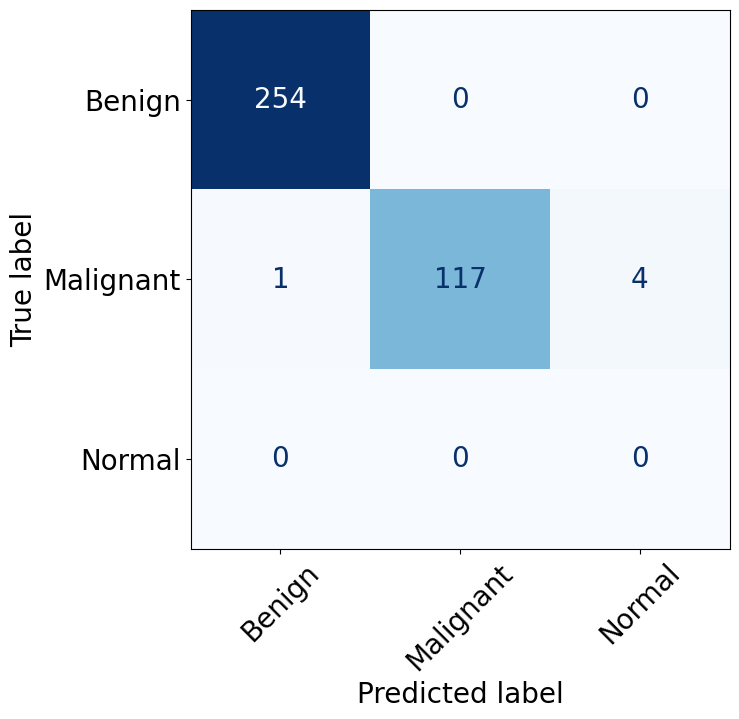

Normalized confusion matrix


C:\Users\PC-Home\AppData\Local\Temp\ipykernel_15460\531958273.py:31: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


In [40]:
cm = confusion_matrix(y_true_img, y_pred_img)
    # cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # plot the confusion matrix

display_labels = [ 'Benign','Malignant', 'Normal']
plot_cm(cm, display_labels=display_labels)

display_labels = [ 'Benign','Malignant', 'Normal']
plot_cm_by_me(y_true_img, y_pred_img, classes=display_labels,  normalize=True)
plt.show()